### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist

pd.set_option('display.max_colwidth', None)

Настройка шрифтов для отображения текста в таблице

In [2]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 16px;
}
.dataframe td {
    font-size: 14px;
}
</style>

## Data loading

In [3]:
train_ds = pd.read_csv('data/c_train.csv')
test_ds = pd.read_csv('data/c_test.csv')

In [4]:
train_ds.head()

,cleaned,is_fake
0,москвич владимир клутин приходить счет вмешательство американский выборы,1
1,агент кокорин называть езда встречок житейский история,0
2,госдума рассматривать возможность введение секретный статья уголовный кодекс,1
3,фас заблокировать поставка скоростной трамвай москва,0
4,против навальный заводить дело недоносительство волков,1


In [5]:
train_ds.describe()

,is_fake
count,5758.000000
mean,0.500000
std,0.500043
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [6]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cleaned  1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


## EDA

In [7]:
pd.DataFrame({'Ratio': [np.sum(train_ds.is_fake == 1) / train_ds.shape[0], 
                        np.sum(train_ds.is_fake == 0) / train_ds.shape[0]]}, index=['is_fake', 'real'])

,Ratio
is_fake,0.5
real,0.5


Отсюда видно, что датасет сбалансирован

In [8]:
train_ds['word_count'] = [len(t.split(' ')) for t in train_ds.cleaned]

In [9]:
train_ds.head()

,cleaned,is_fake,word_count
0,москвич владимир клутин приходить счет вмешательство американский выборы,1,8
1,агент кокорин называть езда встречок житейский история,0,7
2,госдума рассматривать возможность введение секретный статья уголовный кодекс,1,8
3,фас заблокировать поставка скоростной трамвай москва,0,6
4,против навальный заводить дело недоносительство волков,1,6


Среднее кол-во слов в предложении: 7.1


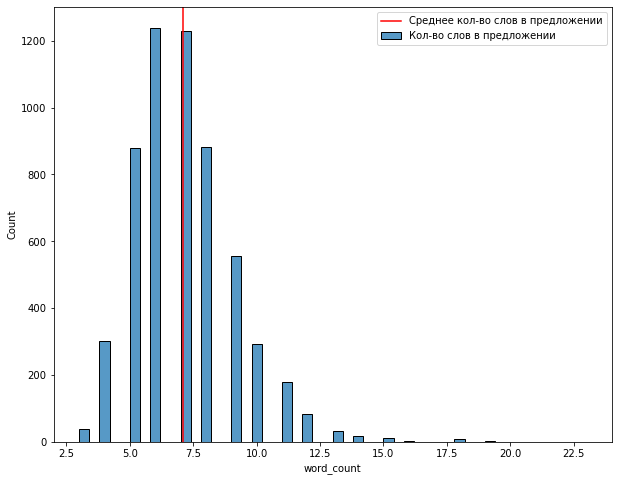

In [10]:
plt.figure(figsize=(10, 8))

sns.histplot(x=train_ds.word_count, bins=50, label='Кол-во слов в предложении')
plt.axvline(np.mean(train_ds.word_count), color = 'r', label = 'Среднее кол-во слов в предложении')

plt.legend()

print('Среднее кол-во слов в предложении:', round(np.mean(train_ds.word_count), 1))

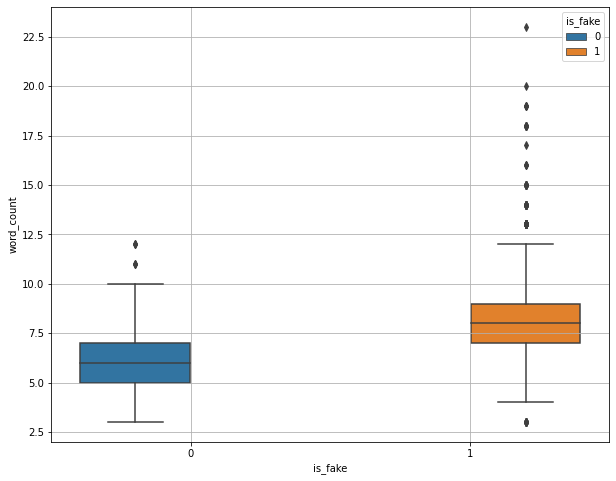

In [11]:
plt.figure(figsize=(10, 8))

sns.boxplot(x='is_fake', y='word_count', hue='is_fake', data=train_ds)
plt.grid()

Данный график показывает, что ложные заголовки длиннее реальных 

Построим облако слов, которое покажет наиболее часто встречающиеся слова

In [12]:
def get_all_words(sentence_series: pd.Series) -> list:
    result = list()
    
    for sentence in sentence_series:
        result += sentence.split(' ')
        
    return result

In [13]:
all_words = get_all_words(pd.concat([train_ds.cleaned, test_ds.cleaned]))

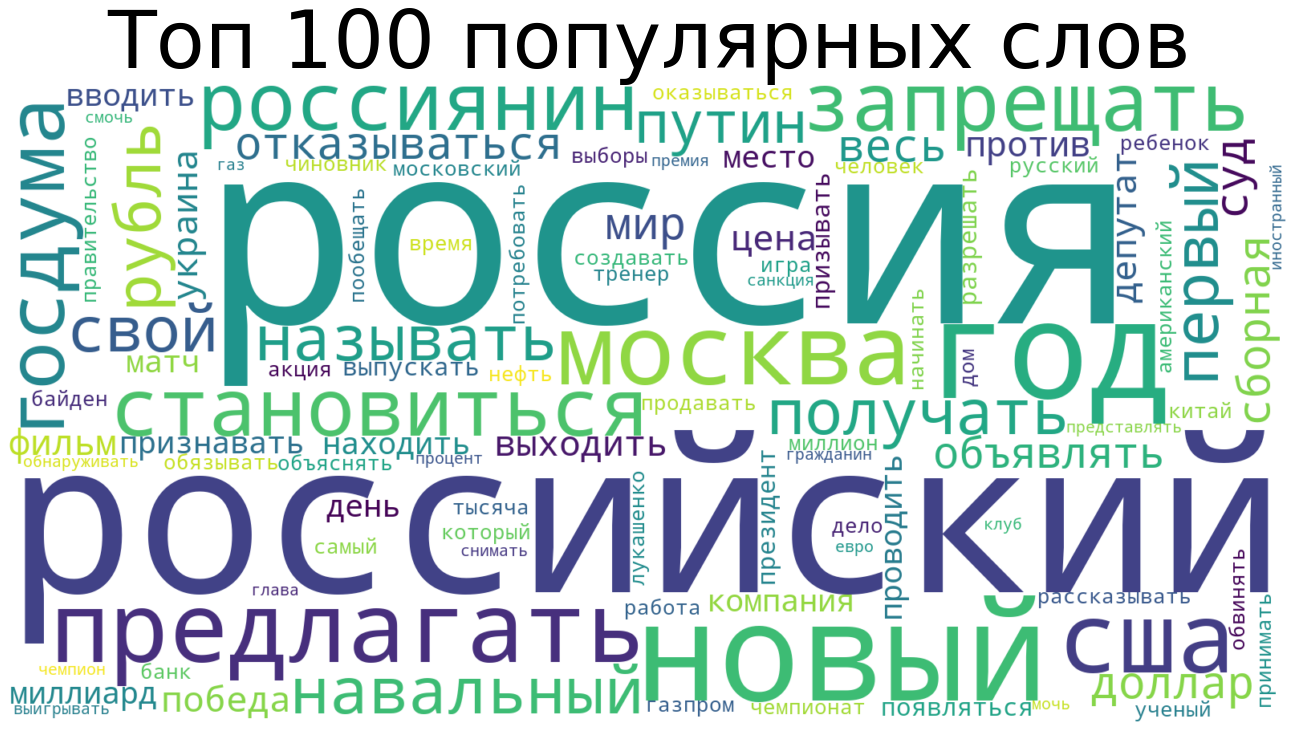

In [14]:
most_common = FreqDist(all_words).most_common(100)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(' '.join([i[0] for i in most_common]))

plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Топ 100 популярных слов', fontsize=80)
plt.tight_layout(pad=0)
plt.show()

Отсюда видно, что новости в основном носят политический характер

А теперь посмотрим на популярные слова, которые появляются в разных типах заголовков. Возможно есть слова, которые являются *маркерами*, указывающими на фейковые новости

In [15]:
top_words_count = 25

real_news_all_words = get_all_words(train_ds[train_ds.is_fake == 0].cleaned)
fake_news_all_words = get_all_words(train_ds[train_ds.is_fake == 1].cleaned)

real_news_top_words = FreqDist(real_news_all_words).most_common(top_words_count)
fake_news_top_words = FreqDist(fake_news_all_words).most_common(top_words_count)

In [16]:
# Увеличиваем размер шрифта на графиках
plt.rcParams.update({'font.size': 20})

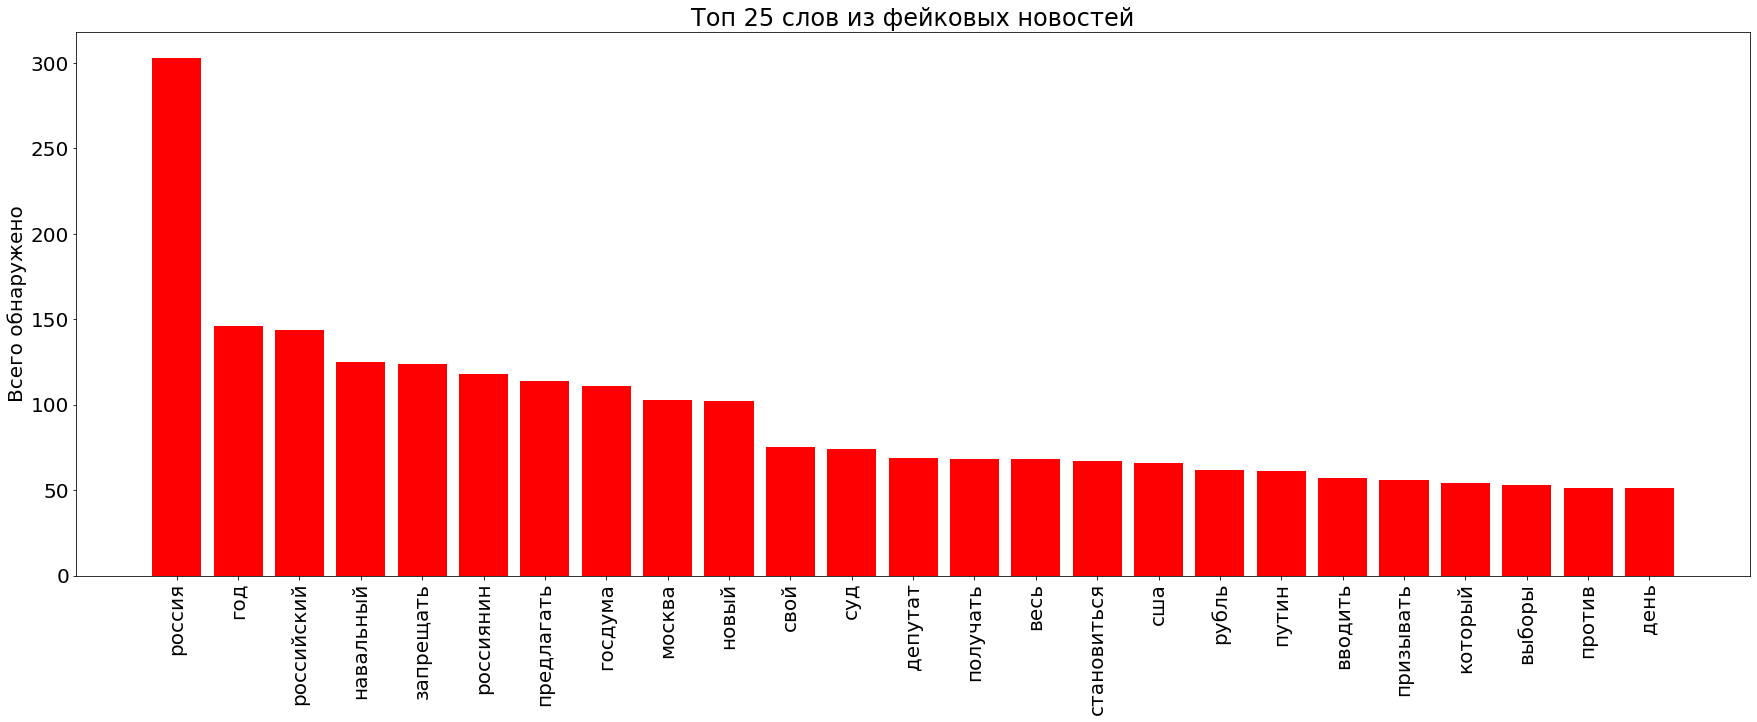

In [17]:
plt.figure(figsize=(30, 10))

plt.title(f"Топ {top_words_count} слов из фейковых новостей")
plt.bar([i[0] for i in fake_news_top_words], [i[1] for i in fake_news_top_words], color='r')
plt.xticks(rotation=90)
plt.ylabel('Всего обнаружено');

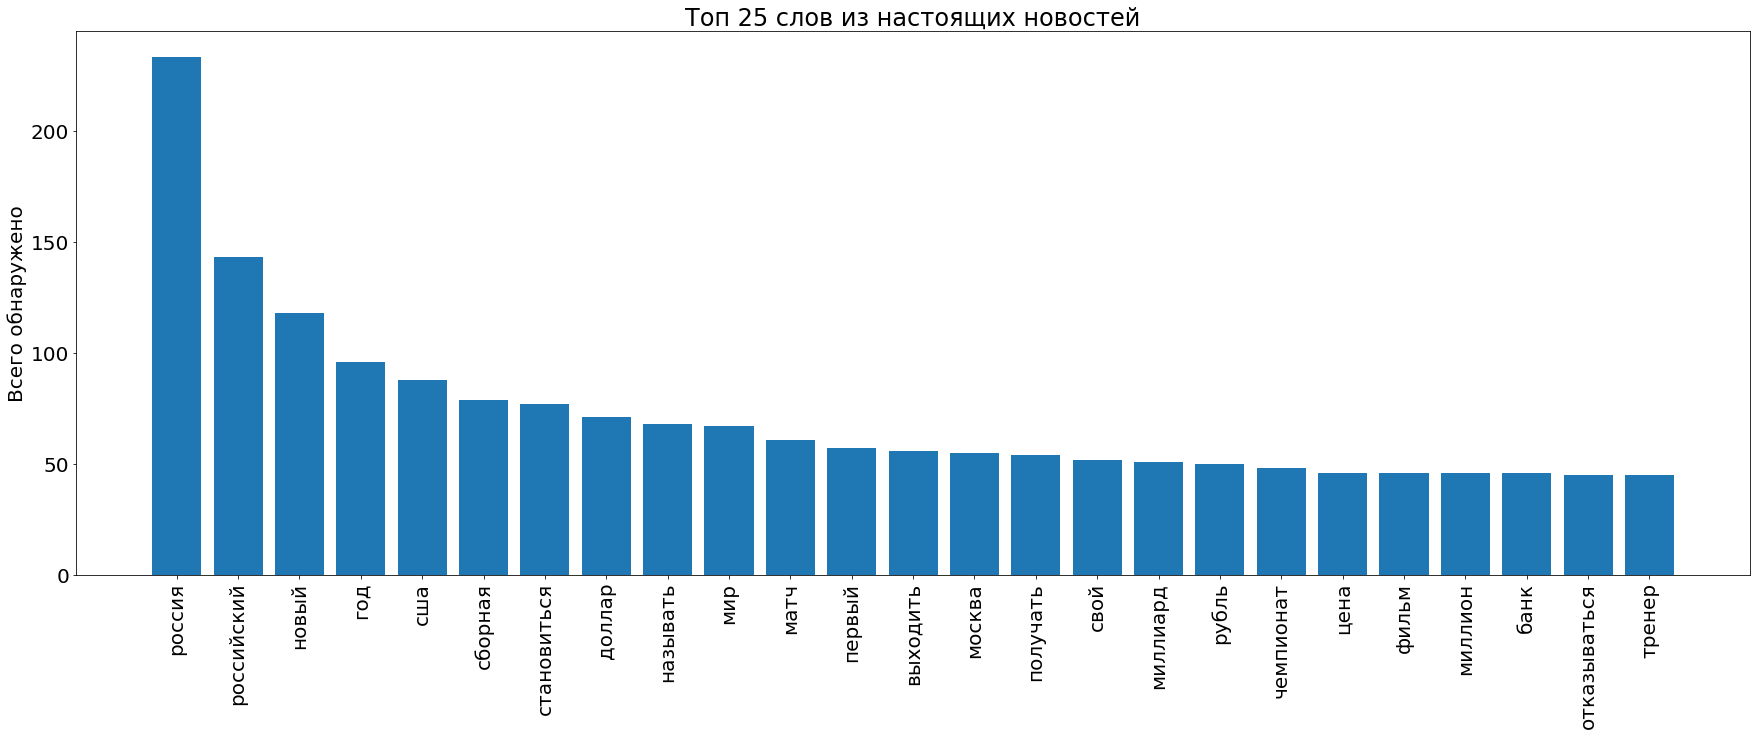

In [18]:
plt.figure(figsize=(30, 10))

plt.title(f"Топ {top_words_count} слов из настоящих новостей")
plt.bar([i[0] for i in real_news_top_words], [i[1] for i in real_news_top_words])
plt.xticks(rotation=90)
plt.ylabel('Всего обнаружено');

Выделим слова, которые появились в топе фейков, но не появились в топе настоящих новостей:

In [19]:
fk_words_set = set([i[0] for i in fake_news_top_words])
rl_words_set = set([i[0] for i in real_news_top_words])

news_words_difference =  fk_words_set.difference(rl_words_set)

print("Слова, которые были в топе фейковых новостей, но не оказались в топе настоящих")
for word in fk_words_set.difference(news_words_difference):
    print(f'-> {word}')

Слова, которые были в топе фейковых новостей, но не оказались в топе настоящих
-> год
-> россия
-> получать
-> свой
-> сша
-> москва
-> новый
-> российский
-> рубль
-> становиться


Посмотрим, будут ли эти слова показывать на ложные новости

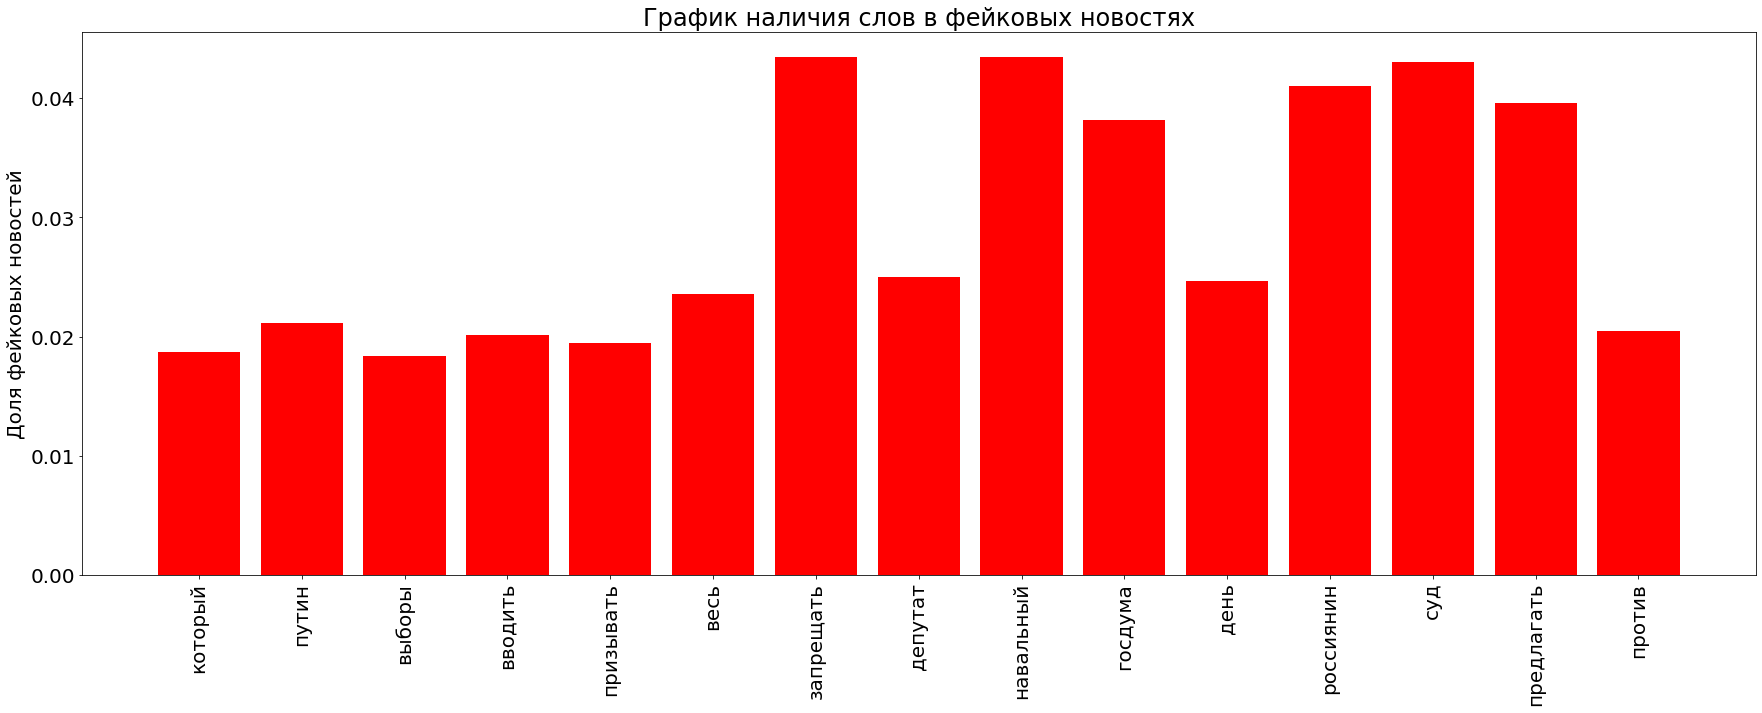

In [20]:
plt.figure(figsize=(30, 10))

words_ratio = dict()

for t_word in news_words_difference:
    words_ratio[t_word] = sum(train_ds[train_ds.is_fake == 1].cleaned \
                              .apply(lambda t_sentence: t_word in t_sentence)) / train_ds[train_ds.is_fake == 1].shape[0]
    
plt.title("График наличия слов в фейковых новостях")
plt.ylabel("Доля фейковых новостей")
plt.bar(words_ratio.keys(), words_ratio.values(), color='r')
plt.xticks(rotation=90);

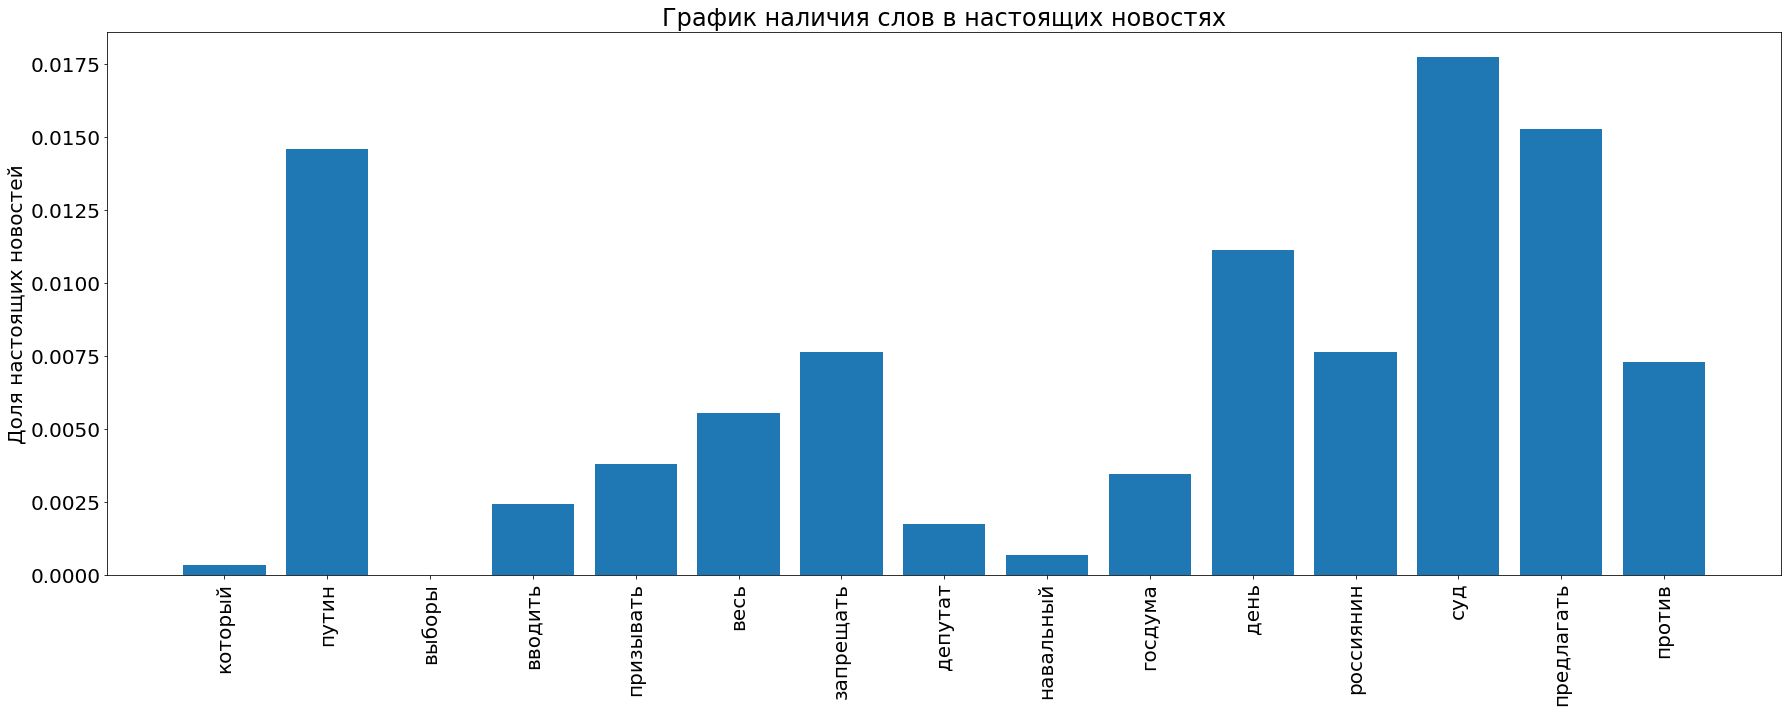

In [21]:
plt.figure(figsize=(30, 10))

words_ratio = dict()

for t_word in news_words_difference:
    words_ratio[t_word] = sum(train_ds[train_ds.is_fake == 0].cleaned \
                              .apply(lambda t_sentence: t_word in t_sentence)) / train_ds[train_ds.is_fake == 0].shape[0]
    
plt.title("График наличия слов в настоящих новостях")
plt.ylabel("Доля настоящих новостей")
plt.bar(words_ratio.keys(), words_ratio.values())
plt.xticks(rotation=90);

# Идеи:
* Уникальность слов в предложении(т.е если очень часто что-то повторяется, то это навязывание)